In [ ]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = '/content/drive/MyDrive/Pneumonia FL/train/'
test_dir = '/content/drive/MyDrive/Pneumonia FL/test/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

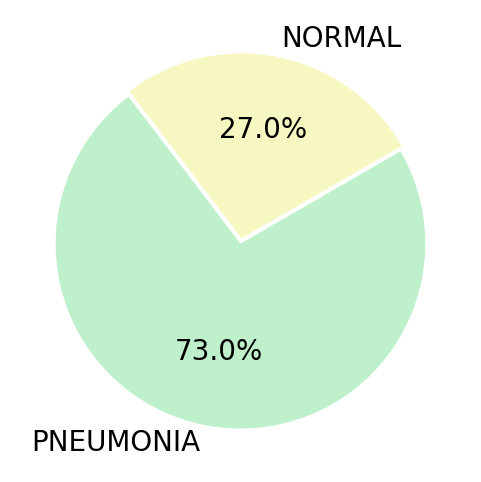

In [ ]:
plt.figure(figsize=(14,6))
colors = ['#F6F7C1', '#BEF0CB']
plt.rcParams.update({'font.size': 20})
plt.pie([len([x for x in train_labels if x=='NORMAL']),
         len([x for x in train_labels if x=='PNEUMONIA'])],
        labels=['NORMAL','PNEUMONIA'],
        colors=colors, autopct='%.1f%%', explode=(0.015,0.015),
        startangle=30);

In [ ]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

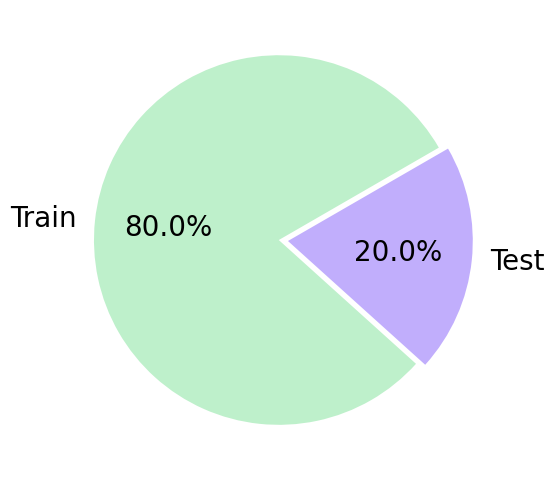

In [ ]:
plt.figure(figsize=(14,6))
colors = ['#BEF0CB', '#C1AEFC']
plt.rcParams.update({'font.size': 20})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

In [ ]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

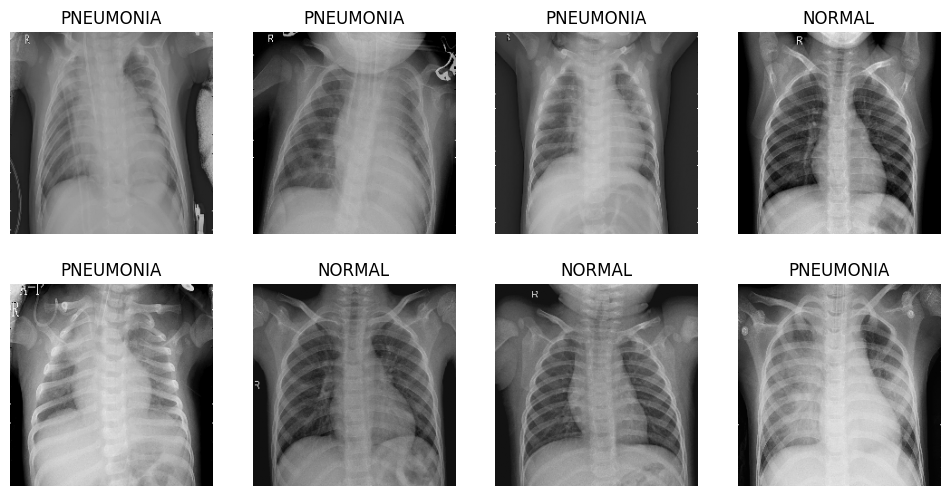

In [ ]:
IMAGE_SIZE = 224

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 20})
plt.show()

In [ ]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization

In [ ]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

mob   = MobileNet(include_top=False, input_shape=input_shape)(inputs)
vgg      = VGG16(include_top=False, input_shape=input_shape)(inputs)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(mob), GlobalAveragePooling2D()(vgg)])
outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(128,activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(lr=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)           3228864   ['input_1[0][0]']             
 onal)                                                                                            
                                                                                                  
 vgg16 (Functional)          (None, 7, 7, 512)            1471468   ['input_1[0][0]']             
                                                          8                                       
                                                                                              

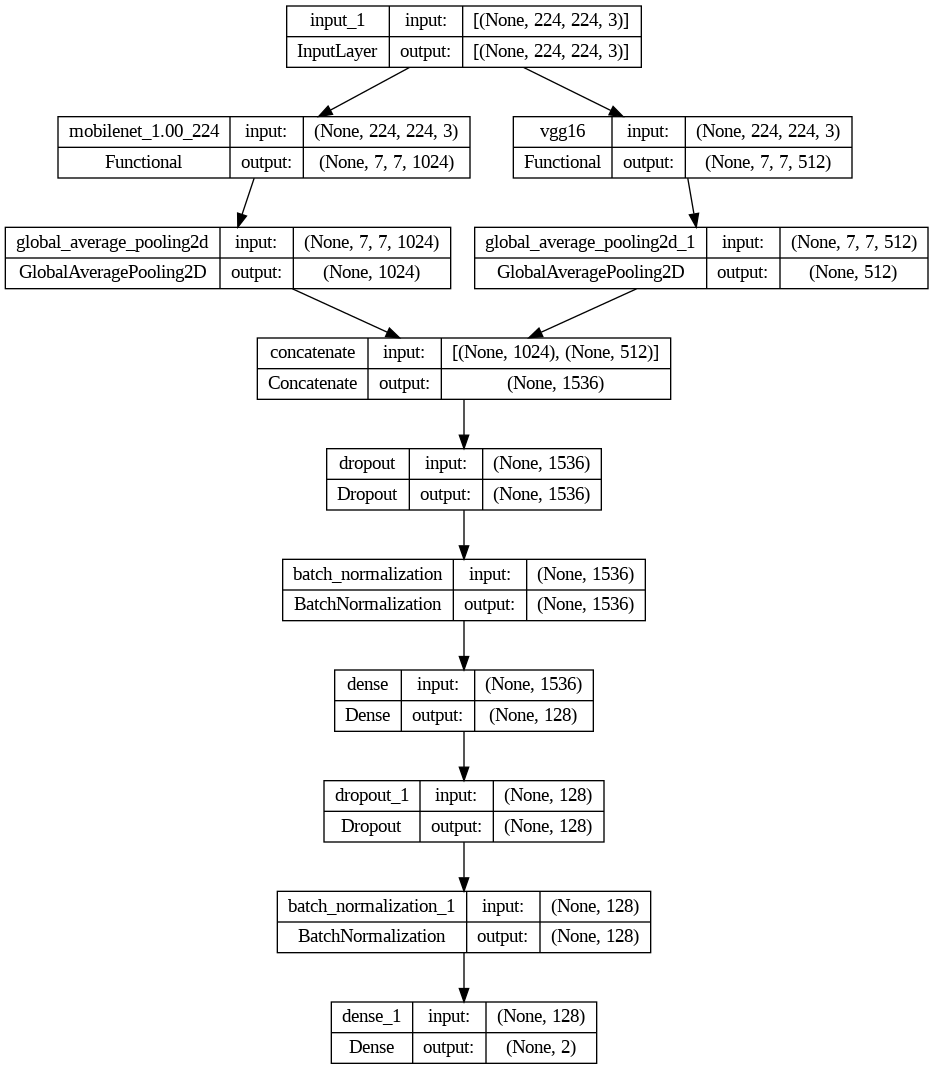

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [ ]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
234/234 [==============================] - 757s 3s/step - loss: 0.3181 - sparse_categorical_accuracy: 0.8791
Epoch 2/10
234/234 [==============================] - 92s 367ms/step - loss: 0.1565 - sparse_categorical_accuracy: 0.9507
Epoch 3/10
234/234 [==============================] - 86s 368ms/step - loss: 0.0913 - sparse_categorical_accuracy: 0.9706
Epoch 4/10
234/234 [==============================] - 85s 363ms/step - loss: 0.0882 - sparse_categorical_accuracy: 0.9717
Epoch 5/10
234/234 [==============================] - 85s 363ms/step - loss: 0.0657 - sparse_categorical_accuracy: 0.9790
Epoch 6/10
234/234 [==============================] - 86s 369ms/step - loss: 0.0427 - sparse_categorical_accuracy: 0.9871
Epoch 7/10
234/234 [==============================] - 85s 363ms/step - loss: 0.0309 - sparse_categorical_accuracy: 0.9927
Epoch 8/10
234/234 [==============================] - 85s 364ms/step - loss: 0.0336 - sparse_categorical_accuracy: 0.9880
Epoch 9/10
234/234 [======

# Federated Learning Based transfer Learning enabled VGG16+MobileNet Model

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the number of clients and the number of training rounds
NUM_CLIENTS = 4
NUM_ROUNDS = 3


# Define the clients and their data
clients = []
for i in range(NUM_CLIENTS):
    client_data = train_paths[i * (len(train_paths) // NUM_CLIENTS):(i + 1) * (len(train_paths) // NUM_CLIENTS)]
    client_labels = train_labels[i * (len(train_labels) // NUM_CLIENTS):(i + 1) * (len(train_labels) // NUM_CLIENTS)]
    clients.append((client_data, client_labels))

# Federated learning loop
for round_num in range(NUM_ROUNDS):

    # Select clients
    selected_client_indices = np.random.choice(len(clients), size=int(NUM_CLIENTS * 0.5), replace=False)
    selected_clients = [clients[i] for i in selected_client_indices]

    # Transmit the global model to the selected clients
    for client in selected_clients:
        client_model = tf.keras.models.clone_model(model)
        client_model.set_weights(model.get_weights())

        # Compile the client model
        client_model.compile(optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])

        steps_per_epoch = int(len(client[0]) / 20)


        client_model.fit(datagen(client[0],client[1], batch_size=batch_size, epochs=epochs),
                         epochs=5, steps_per_epoch=steps_per_epoch)

        # Train locally
        steps_per_epoch = int(len(client[0]) / 20)

        # Aggregate the model
        new_weights = []
        for layer_index in range(len(model.get_weights())):
            new_layer_weights = np.mean([client_model.get_weights()[layer_index], model.get_weights()[layer_index]], axis=0)
            new_weights.append(new_layer_weights)
        model.set_weights(new_weights)


batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

model.save('my_model.h5')

Epoch 1/5
58/58 [==============================] - 37s 374ms/step - loss: 0.0462 - sparse_categorical_accuracy: 0.9845
Epoch 2/5
58/58 [==============================] - 31s 372ms/step - loss: 0.0535 - sparse_categorical_accuracy: 0.9826
Epoch 3/5
58/58 [==============================] - 21s 356ms/step - loss: 0.0228 - sparse_categorical_accuracy: 0.9939
Epoch 4/5
58/58 [==============================] - 21s 359ms/step - loss: 0.0328 - sparse_categorical_accuracy: 0.9896
Epoch 5/5
58/58 [==============================] - 22s 379ms/step - loss: 0.0198 - sparse_categorical_accuracy: 0.9939
Epoch 1/5
58/58 [==============================] - 37s 377ms/step - loss: 0.0147 - sparse_categorical_accuracy: 0.9966
Epoch 2/5
58/58 [==============================] - 21s 370ms/step - loss: 0.0098 - sparse_categorical_accuracy: 0.9965
Epoch 3/5
58/58 [==============================] - 21s 360ms/step - loss: 0.0050 - sparse_categorical_accuracy: 1.0000
Epoch 4/5
58/58 [==============================]

  0%|          | 0/36 [00:00<?, ?it/s]

1/1 [==============================] - 8s 8s/step


  3%|▎         | 1/36 [00:25<15:05, 25.88s/it]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 2/36 [00:39<10:38, 18.79s/it]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 3/36 [00:53<09:06, 16.57s/it]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 4/36 [01:06<08:05, 15.17s/it]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 5/36 [01:20<07:34, 14.65s/it]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 6/36 [01:33<07:03, 14.13s/it]

1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 7/36 [02:16<11:26, 23.68s/it]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 8/36 [02:30<09:30, 20.37s/it]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 9/36 [02:43<08:09, 18.13s/it]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 10/36 [02:56<07:07, 16.44s/it]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 11/36 [03:08<06:23, 15.34s/it]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 12/36 [03:21<05:51, 14.66s/it]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 13/36 [03:35<05:26, 14.21s/it]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 14/36 [03:47<05:00, 13.64s/it]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 15/36 [03:59<04:34, 13.08s/it]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 16/36 [04:11<04:17, 12.87s/it]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 17/36 [04:23<04:00, 12.65s/it]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 18/36 [04:36<03:47, 12.66s/it]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 19/36 [04:49<03:36, 12.71s/it]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 20/36 [05:01<03:21, 12.59s/it]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 21/36 [05:19<03:32, 14.18s/it]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 22/36 [05:31<03:11, 13.65s/it]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 23/36 [05:44<02:52, 13.25s/it]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 24/36 [05:56<02:37, 13.09s/it]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 25/36 [06:09<02:21, 12.87s/it]

1/1 [==============================] - 0s 63ms/step


 72%|███████▏  | 26/36 [06:21<02:06, 12.62s/it]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 27/36 [06:34<01:54, 12.72s/it]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 28/36 [06:46<01:40, 12.57s/it]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 29/36 [06:58<01:27, 12.52s/it]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 30/36 [07:11<01:15, 12.57s/it]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 31/36 [07:24<01:03, 12.70s/it]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 32/36 [07:37<00:51, 12.76s/it]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 33/36 [07:57<00:44, 14.90s/it]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 34/36 [08:09<00:28, 14.08s/it]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 35/36 [08:23<00:14, 14.06s/it]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 36/36 [08:34<00:00, 13.20s/it]

1/1 [==============================] - 1s 561ms/step


37it [08:43, 14.15s/it]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      NORMAL       0.95      0.96      0.96       317
   PNEUMONIA       0.99      0.98      0.98       855

    accuracy                           0.98      1172
   macro avg       0.97      0.97      0.97      1172
weighted avg       0.98      0.98      0.98      1172



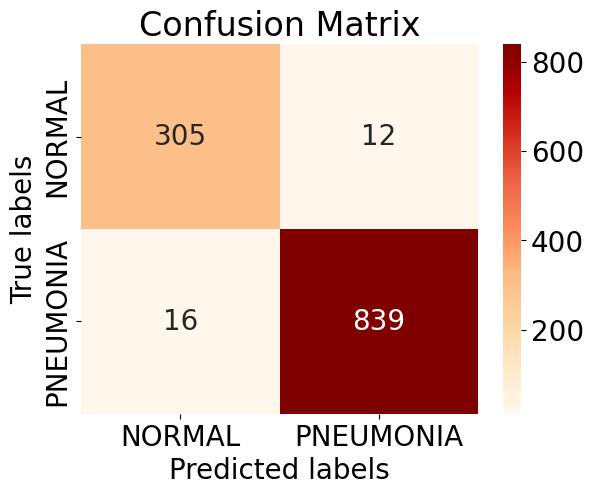

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_true, y_pred)

ax= plt.subplot()
sns.heatmap(cm, cmap="OrRd", fmt="d", annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['NORMAL', 'PNEUMONIA']); ax.yaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
plt.savefig('CM_heatmap',dpi=400)

In [ ]:
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]
print('TP: %f' % TP,'TN: %f' % TN, 'FP: %f' % FP, 'FN: %f' % FN)

acc=(TP+TN)/float(TP+TN+FP+FN)
print(' acc: %.4f' % acc)
recall=TP/float(TP+FN)
print(' Recall: %.4f' % recall)
precision=TP/float(TP+FP)
print(' Precision: %.4f' % precision)
f1=(2*precision*recall)/(recall+precision)
print('F1 Score: %.4f' % f1)

TP: 839.000000 TN: 305.000000 FP: 12.000000 FN: 16.000000
 acc: 0.9761
 Recall: 0.9813
 Precision: 0.9859
F1 Score: 0.9836


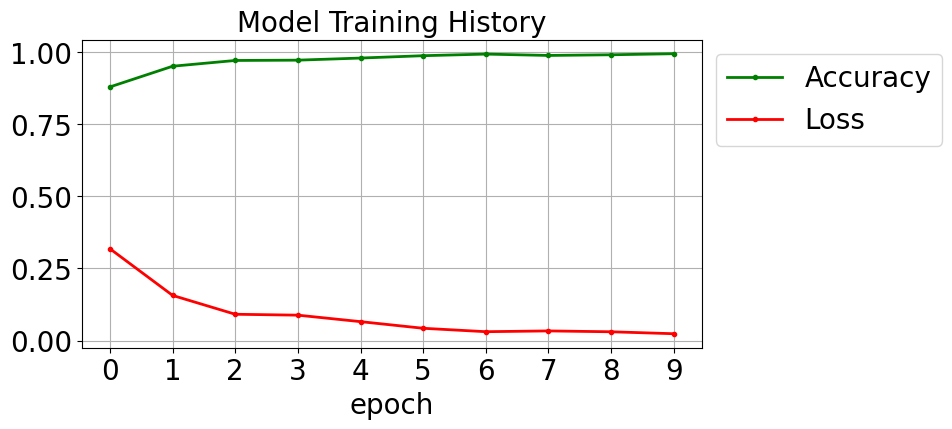

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History',fontsize =20)
plt.xlabel('epoch', fontsize =20)
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1), fontsize =20)
plt.show()

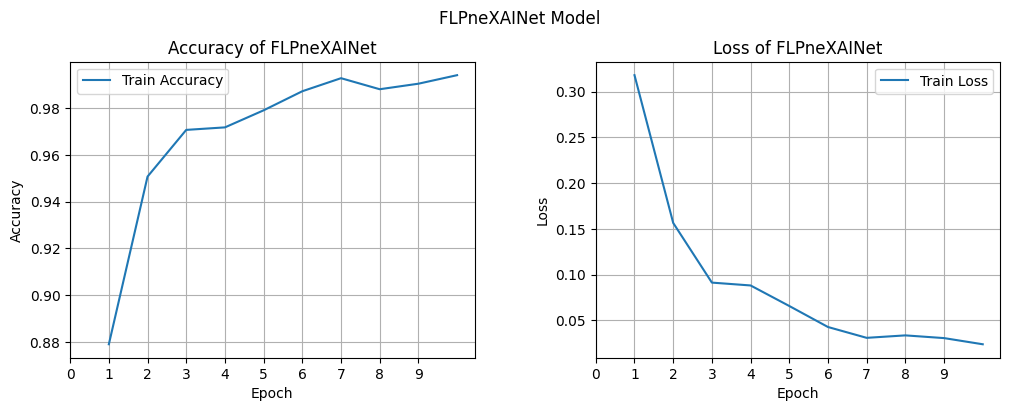

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('default')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('FLPneXAINet Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,11))
ax1.plot(epoch_list, history.history['sparse_categorical_accuracy'], label='Train Accuracy')
#ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks([x for x in range(epochs)])
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy of FLPneXAINet')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
#ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks([x for x in range(epochs)])
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss of FLPneXAINet')
l2 = ax2.legend(loc="best")
plt.savefig('curve1',dpi=400)

In [ ]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/36 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 1/36 [00:00<00:20,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 2/36 [00:01<00:18,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 3/36 [00:01<00:18,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 4/36 [00:02<00:18,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 5/36 [00:02<00:18,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 6/36 [00:03<00:17,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 7/36 [00:04<00:17,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 8/36 [00:04<00:16,  1.68it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 9/36 [00:05<00:16,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 10/36 [00:05<00:15,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 11/36 [00:06<00:15,  1.64it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 12/36 [00:07<00:16,  1.45it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 13/36 [00:08<00:16,  1.40it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 14/36 [00:09<00:16,  1.30it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 15/36 [00:09<00:15,  1.32it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 16/36 [00:10<00:13,  1.44it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 17/36 [00:10<00:12,  1.49it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 18/36 [00:11<00:11,  1.52it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 19/36 [00:12<00:10,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 20/36 [00:12<00:10,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 21/36 [00:13<00:09,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 22/36 [00:14<00:08,  1.64it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 23/36 [00:14<00:07,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 24/36 [00:15<00:07,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 25/36 [00:15<00:07,  1.53it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 26/36 [00:16<00:06,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 27/36 [00:17<00:05,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 28/36 [00:17<00:04,  1.62it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 29/36 [00:18<00:04,  1.48it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 30/36 [00:19<00:03,  1.55it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 31/36 [00:19<00:03,  1.44it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 32/36 [00:20<00:03,  1.31it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 33/36 [00:21<00:02,  1.33it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 34/36 [00:22<00:01,  1.23it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 35/36 [00:23<00:00,  1.31it/s]

1/1 [==============================] - 0s 30ms/step


100%|██████████| 36/36 [00:23<00:00,  1.44it/s]

1/1 [==============================] - 0s 28ms/step


37it [00:24,  1.53it/s]


              precision    recall  f1-score   support

      NORMAL       0.95      0.96      0.96       317
   PNEUMONIA       0.98      0.98      0.98       855

    accuracy                           0.98      1172
   macro avg       0.97      0.97      0.97      1172
weighted avg       0.98      0.98      0.98      1172



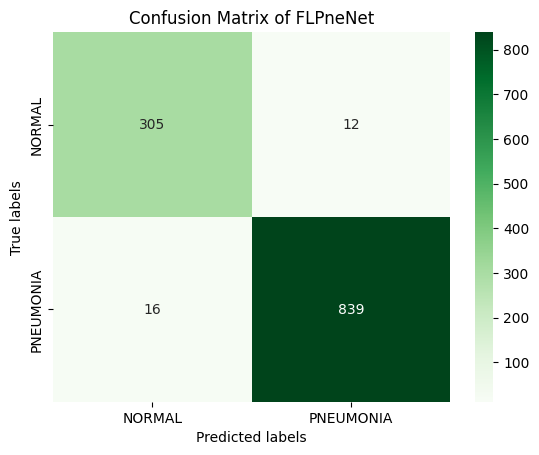

In [ ]:
print(classification_report(y_true, y_pred))

import seaborn as sns
import matplotlib.pyplot as plt

ax= plt.subplot()
sns.heatmap(cm, cmap="Greens", fmt="d", annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix of FLPneNet');
ax.xaxis.set_ticklabels(['NORMAL', 'PNEUMONIA']); ax.yaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
plt.savefig('CM_heatmap',dpi=400)

              precision    recall  f1-score   support

      NORMAL       0.95      0.96      0.96       317
   PNEUMONIA       0.98      0.98      0.98       855

    accuracy                           0.98      1172
   macro avg       0.97      0.97      0.97      1172
weighted avg       0.98      0.98      0.98      1172



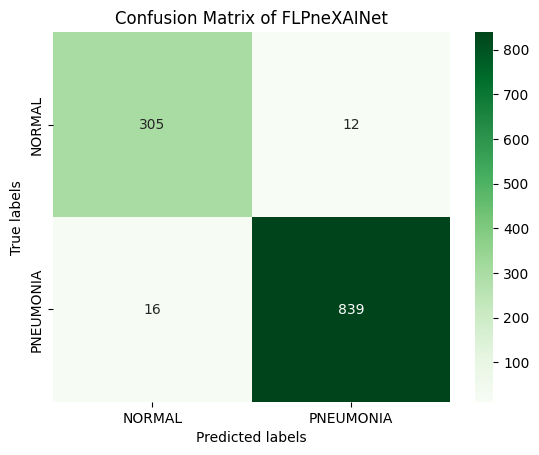

In [ ]:
print(classification_report(y_true, y_pred))

import seaborn as sns
import matplotlib.pyplot as plt

ax= plt.subplot()
sns.heatmap(cm, cmap="Greens", fmt="d", annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix of FLPneXAINet');
ax.xaxis.set_ticklabels(['NORMAL', 'PNEUMONIA']); ax.yaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
plt.savefig('CM_heatmap',dpi=400)

              precision    recall  f1-score   support

      NORMAL       0.95      0.96      0.96       317
   PNEUMONIA       0.98      0.98      0.98       855

    accuracy                           0.98      1172
   macro avg       0.97      0.97      0.97      1172
weighted avg       0.98      0.98      0.98      1172



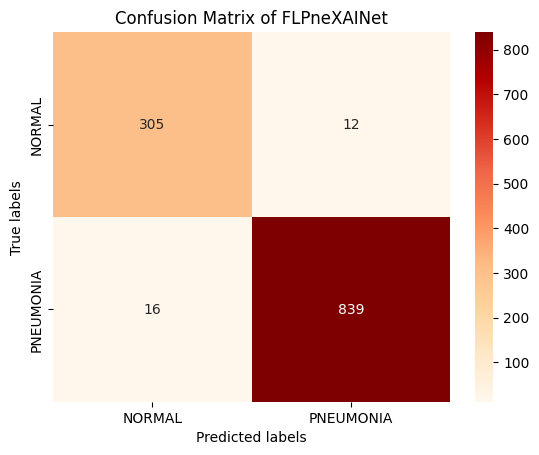

In [ ]:
print(classification_report(y_true, y_pred))

import seaborn as sns
import matplotlib.pyplot as plt

ax= plt.subplot()
sns.heatmap(cm, cmap="OrRd", fmt="d", annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix of FLPneXAINet');
ax.xaxis.set_ticklabels(['NORMAL', 'PNEUMONIA']); ax.yaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
plt.savefig('CM_heatmap',dpi=400)

In [ ]:
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]
print('TP: %f' % TP,'TN: %f' % TN, 'FP: %f' % FP, 'FN: %f' % FN)

acc=(TP+TN)/float(TP+TN+FP+FN)
print(' acc: %.4f' % acc)
recall=TP/float(TP+FN)
print(' Recall: %.4f' % recall)
precision=TP/float(TP+FP)
print(' Precision: %.4f' % precision)
f1=(2*precision*recall)/(recall+precision)
print('F1 Score: %.4f' % f1)

TP: 839.000000 TN: 305.000000 FP: 12.000000 FN: 16.000000
 acc: 0.9761
 Recall: 0.9813
 Precision: 0.9859
F1 Score: 0.9836
